In [12]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
import math

In [13]:
steam = pd.read_csv('data/steam.csv')
steam.columns

Index(['appid', 'name', 'release_date', 'english', 'developer', 'publisher',
       'platforms', 'required_age', 'categories', 'genres', 'steamspy_tags',
       'achievements', 'positive_ratings', 'negative_ratings',
       'average_playtime', 'median_playtime', 'owners', 'price'],
      dtype='object')

In [14]:
steam_description = pd.read_csv('data/steam_description_data.csv')
steam_description.columns

Index(['steam_appid', 'detailed_description', 'about_the_game',
       'short_description'],
      dtype='object')

In [15]:
steam = pd.merge(steam, steam_description, left_on='appid', right_on='steam_appid', how='inner')
steam.head()

,appid,name,release_date,english,developer,publisher,platforms,required_age,categories,genres,...,positive_ratings,negative_ratings,average_playtime,median_playtime,owners,price,steam_appid,detailed_description,about_the_game,short_description
0,10,Counter-Strike,2000-11-01,1,Valve,Valve,windows;mac;linux,0,Multi-player;Online Multi-Player;Local Multi-P...,Action,...,124534,3339,17612,317,10000000-20000000,7.19,10,Play the world's number 1 online action game. ...,Play the world's number 1 online action game. ...,Play the world's number 1 online action game. ...
1,20,Team Fortress Classic,1999-04-01,1,Valve,Valve,windows;mac;linux,0,Multi-player;Online Multi-Player;Local Multi-P...,Action,...,3318,633,277,62,5000000-10000000,3.99,20,One of the most popular online action games of...,One of the most popular online action games of...,One of the most popular online action games of...
2,30,Day of Defeat,2003-05-01,1,Valve,Valve,windows;mac;linux,0,Multi-player;Valve Anti-Cheat enabled,Action,...,3416,398,187,34,5000000-10000000,3.99,30,Enlist in an intense brand of Axis vs. Allied ...,Enlist in an intense brand of Axis vs. Allied ...,Enlist in an intense brand of Axis vs. Allied ...
3,40,Deathmatch Classic,2001-06-01,1,Valve,Valve,windows;mac;linux,0,Multi-player;Online Multi-Player;Local Multi-P...,Action,...,1273,267,258,184,5000000-10000000,3.99,40,Enjoy fast-paced multiplayer gaming with Death...,Enjoy fast-paced multiplayer gaming with Death...,Enjoy fast-paced multiplayer gaming with Death...
4,50,Half-Life: Opposing Force,1999-11-01,1,Gearbox Software,Valve,windows;mac;linux,0,Single-player;Multi-player;Valve Anti-Cheat en...,Action,...,5250,288,624,415,5000000-10000000,3.99,50,Return to the Black Mesa Research Facility as ...,Return to the Black Mesa Research Facility as ...,Return to the Black Mesa Research Facility as ...


## Problem 3 (a)

In [16]:
steam['clean_description'] = steam['detailed_description'].str.lower().replace('[^a-zA-Z\s]', '', regex=True)

In [21]:
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
import nltk
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\26405\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\26405\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping corpora\stopwords.zip.


True

In [22]:
steam['tokenized_description'] = steam['clean_description'].apply(word_tokenize)

stop_words = set(stopwords.words('english'))
steam['filtered_description'] = steam['tokenized_description'].apply(lambda x: [word for word in x if word not in stop_words])

In [23]:
from mlxtend.frequent_patterns import apriori, association_rules
from mlxtend.preprocessing import TransactionEncoder

te = TransactionEncoder()
te_array = te.fit_transform(steam['filtered_description'])
steam_te = pd.DataFrame(te_array, columns=te.columns_)

frequent_itemsets = apriori(steam_te, min_support=0.2, use_colnames=True)
rules = association_rules(frequent_itemsets, metric="confidence", min_threshold=0.5)

rules

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction,zhangs_metric
0,(different),(game),0.291856,0.687313,0.225706,0.773349,1.125177,0.025110,1.379594,0.157102
1,(new),(game),0.366574,0.687313,0.267221,0.728967,1.060604,0.015269,1.153687,0.090210
2,(one),(game),0.305891,0.687313,0.227442,0.743540,1.081807,0.017199,1.219244,0.108947
3,(play),(game),0.321108,0.687313,0.253924,0.790775,1.150531,0.033223,1.494503,0.192721
4,(time),(game),0.292484,0.687313,0.220203,0.752873,1.095386,0.019175,1.265288,0.123078
5,(world),(game),0.336399,0.687313,0.238079,0.707729,1.029705,0.006868,1.069855,0.043472


## Problem 3 (b)

In [24]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, classification_report

X = steam['filtered_description'].apply(lambda x: ' '.join(x))
y = (steam['positive_ratings'] > steam['negative_ratings']).astype(int)

vectorizer = CountVectorizer(max_features=1000)
X_counts = vectorizer.fit_transform(X)

nb_model = MultinomialNB()
nb_model.fit(X_counts, y)

feature_names = np.array(vectorizer.get_feature_names_out())

log_probabilities = nb_model.feature_log_prob_

top_n = 20  # Adjust as needed
good_game_top_words = feature_names[np.argsort(log_probabilities[1])[::-1][:top_n]]
bad_game_top_words = feature_names[np.argsort(log_probabilities[0])[::-1][:top_n]]

print("Top words for Good Games:")
print(good_game_top_words)

print("\nTop words for Bad Games:")
print(bad_game_top_words)

Top words for Good Games:
['game' 'br' 'new' 'world' 'play' 'different' 'one' 'time' 'players'
 'unique' 'get' 'levels' 'find' 'player' 'way' 'use' 'make' 'story' 'like'
 'games']

Top words for Bad Games:
['game' 'br' 'new' 'world' 'different' 'play' 'one' 'time' 'players' 'get'
 'player' 'find' 'use' 'make' 'levels' 'unique' 'way' 'also' 'like'
 'enemies']


## Problem 4

In [25]:
import networkx as nx

In [26]:
steam['genres'] = steam['genres'].str.split(';')

In [27]:
game_threshold = 100
developer_counts = steam['publisher'].value_counts()
valid_developers = developer_counts[developer_counts >= game_threshold].index
filtered_steam = steam[steam['publisher'].isin(valid_developers)]

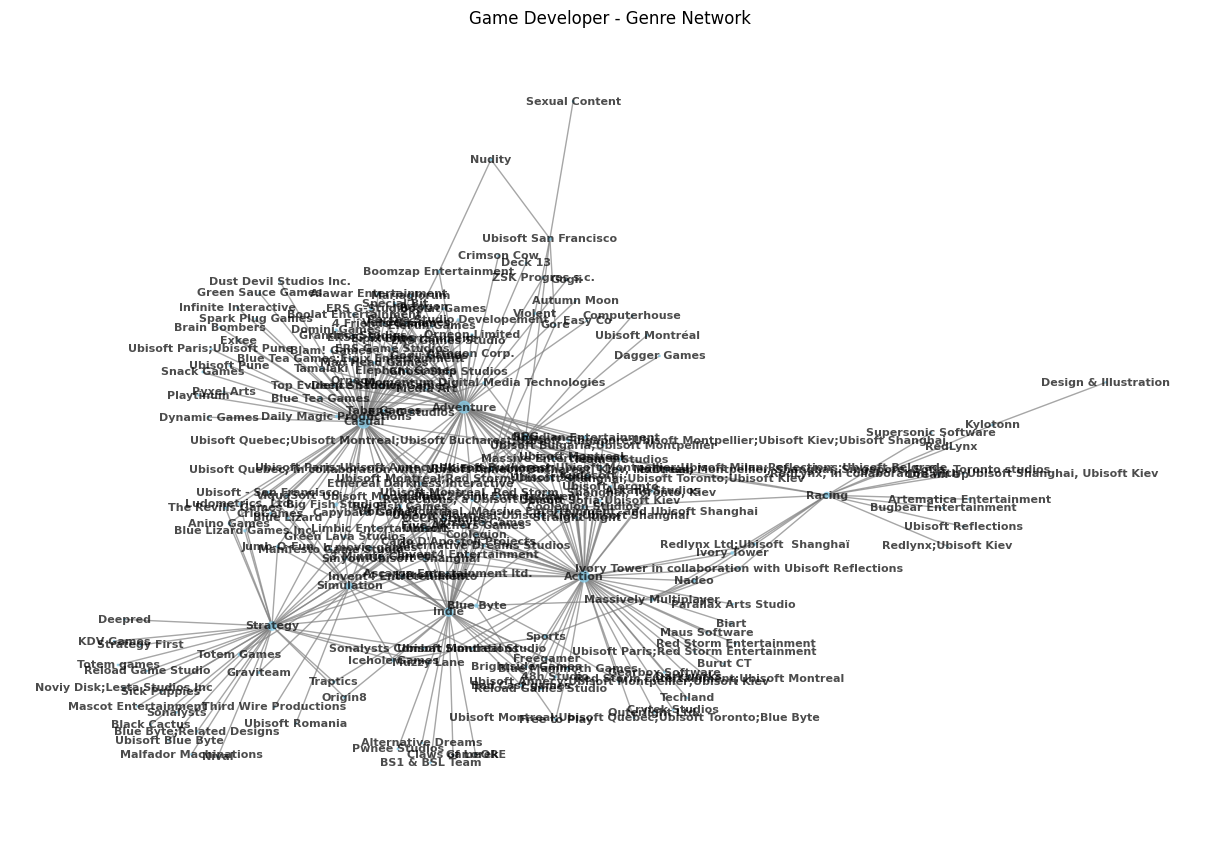

In [28]:
G = nx.Graph()

for developer, games in filtered_steam.groupby('developer'):
    G.add_node(developer, games=len(games))
    
    genres = set()
    for game_genres in games['genres']:
        genres.update(game_genres)
        
    for genre in genres:
        G.add_edge(developer, genre)

pos = nx.spring_layout(G)
node_sizes = [G.degree(developer) for developer in G.nodes]

plt.figure(figsize=(12, 8))
nx.draw(G, pos, with_labels=True, node_size=node_sizes, font_size=8, font_color='black', node_color='skyblue', edge_color='gray', alpha=0.7, font_weight='bold')
plt.title('Game Developer - Genre Network')
plt.show()

In [29]:
top_genres = [genre for genre, degree in sorted(G.degree, key=lambda x: x[1], reverse=True)[:20]]

genre_competitors = {}
genre_dominance = {}

for genre in top_genres:
    producers = [neighbor for neighbor in G.neighbors(genre) if neighbor in valid_developers]
    if len(producers) >= 2:
        genre_competitors[genre] = producers

for producer in valid_developers:
    genres = [neighbor for neighbor in G.neighbors(producer) if neighbor in top_genres]
    if genres:
        max_genre = max(genres, key=lambda g: G.degree(producer, g))
        genre_dominance[producer] = max_genre

# Output results
print("Main Competitors by Top 20 Genres:")
for genre, competitors in genre_competitors.items():
    print(f"Genre: {genre}, Competitors: {competitors}")

Main Competitors by Top 20 Genres:
Genre: Casual, Competitors: ['Big Fish Games', 'Ubisoft']
Genre: Adventure, Competitors: ['Big Fish Games', 'Ubisoft']
Genre: Strategy, Competitors: ['Strategy First', 'Ubisoft']
Genre: Indie, Competitors: ['Big Fish Games', 'Ubisoft']
Genre: Simulation, Competitors: ['Big Fish Games', 'Ubisoft']


In [30]:
print("\nProducer Dominance by Top 20 Genres:")
for producer, dominant_genre in genre_dominance.items():
    print(f"Producer: {producer}, Dominant Genre: {dominant_genre}")


Producer Dominance by Top 20 Genres:
Producer: Big Fish Games, Dominant Genre: Indie
Producer: Strategy First, Dominant Genre: Strategy
Producer: Ubisoft, Dominant Genre: Indie
